# Parameters & Set Up
These parameters let the script know where the data is, the relevant metadata, and set parameters for the figures below.

In [ ]:
################# User Inputs
# Paths
imDir = 'C:\\fullpath\\to\\image\\files' # Folder containing the image files
dataName = '20241107_U2OS_SGRLC_100Xoil_15mintimelapse_01_25plaser' # Name of the image sequence to analyze
dataDir = imDir + '\\OpticalFlow3D\\' + dataName # Directory the flow output is saved in
saveDir = imDir + '\\AnalysisOutput' # Where should the output figures be saved?

# Metadata
xyscale = 0.065 # um/pixel
zscale = 0.2 # um/pixel
tscale = 45/60 # minutes/frame
tstart = 3 # which frames should be analyzed? Indexing starts at zero
tend = 17 # which frames should be analyzed? Indexing starts at zero

# Thresholding
relPer = 90 # reliability threshold percentile

# Consistent visualization parameters
zSlice = 6 # Which z-slice for the 2D visualization?
gap = 6 # How many vectors should be included? All vectors creates a messy plot

In [13]:
################# Python Set up
# Notebook
import tifffile as tf
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib
import colorcet as cc

# Convert paths
imDir = Path(imDir)
dataDir = Path(dataDir)
saveDir = Path(saveDir)

# If the save dir does not exist, make it
saveDir.mkdir(exist_ok=True)

# Load the Data
This section loads the optical flow vectors and the reliability. These are used to derive other metrics that will be of interest.

Reliability threshold = 0.105559126


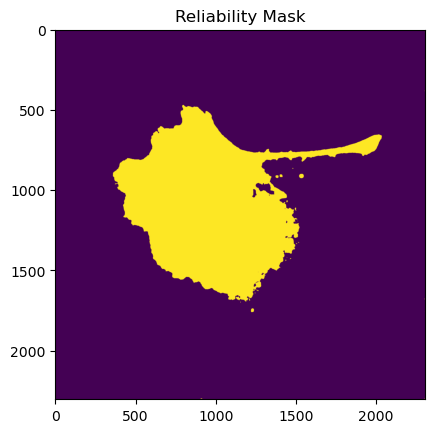

In [3]:
# Reliability thresholding
relFile = dataName + '_rel_t0003.tiff'

rel = tf.imread(dataDir / relFile)
relThresh = np.percentile(rel,relPer)
print('Reliability threshold = ' + str(relThresh))

relMask = rel > relThresh

plt.imshow(relMask[zSlice,:],aspect='equal')
plt.title('Reliability Mask')
plt.show()

In [4]:
# Load and format velocity data

vxFile = dataName + '_vx_t0003.tiff'
vx = tf.imread(dataDir / vxFile)
vx = vx*relMask # Remove unreliable vectors
vx[vx==0] = np.nan
vx = vx*xyscale/tscale # Put into physical units

vyFile = dataName + '_vy_t0003.tiff'
vy = tf.imread(dataDir / vyFile)
vy = vy*relMask # Remove unreliable vectors
vy[vy==0] = np.nan
vy = vy*xyscale/tscale # Put into physical units

vzFile = dataName + '_vz_t0003.tiff'
vz = tf.imread(dataDir / vzFile)
vz = vz*relMask # Remove unreliable vectors
vz[vz==0] = np.nan
vz = vz*zscale/tscale # Put into physical units

In [5]:
# Calculate useful quantities

# Magnitude of intensity motion/change
mag = np.sqrt(np.power(vx,2)+np.power(vy,2)+np.power(vz,2))

# Angle in the xy plane
theta = np.arctan2(vy,vx) # Ranges from -pi to pi

# Angle with respect to the z-axis
phi = np.arctan(vz/np.sqrt(np.power(vx,2)+np.power(vy,2))) # ranges from -pi/2 to pi/2

# Set up a grid for quiver plots
x = np.linspace(0, vx.shape[2]-1, vx.shape[2])*xyscale
y = np.linspace(0, vx.shape[1]-1, vx.shape[1])*xyscale
z = np.linspace(0, vx.shape[0]-1, vx.shape[0])*zscale
X, Y, Z = np.meshgrid(x,y,z)
X = np.moveaxis(X,-1,0)
Y = np.moveaxis(Y,-1,0)
Z = np.moveaxis(Z,-1,0)

# Example Quiver Figure
An example of making a vector plot colored by magnitude. Other variables such as theta or phi could be used for color.

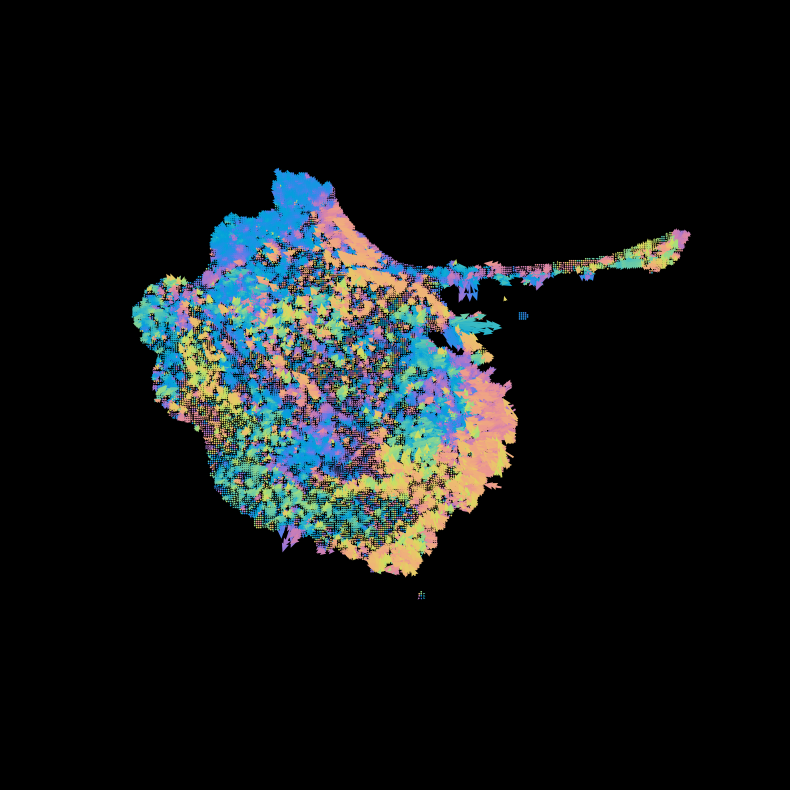

In [6]:
# Quiver based on Theta: 2D view of a z-slice
fig, ax = plt.subplots()
fig.set_figwidth(10)
fig.set_figheight(10)

# Use a consistent colorscale across different figures
norm = matplotlib.colors.Normalize(vmin=-np.pi, vmax=np.pi)
thetaPlot = norm(theta[zSlice,::gap,::gap])
thetaPlot = thetaPlot.flatten()
colormap = cc.m_CET_C8 # See the colorcet gallery for useful colormap choices: https://colorcet.com/gallery.html

# Make the quiver plot
q = ax.quiver(X[zSlice,::gap,::gap],Y[zSlice,::gap,::gap],vx[zSlice,::gap,::gap],vy[zSlice,::gap,::gap],
          color=colormap(thetaPlot),
          scale=1/25,angles='xy',scale_units='xy',units='xy',headwidth=4)

# Format the quiver plot
plt.xlim(np.min(X),np.max(X))
plt.ylim(np.max(Y),np.min(Y))
ax.set_aspect('equal')
plt.axis('off')
fig.set_facecolor("black")

# Save and show
saveName = 'ExampleThetaQuiver.png'
plt.savefig(saveDir / saveName, dpi=300, bbox_inches='tight')
plt.show()

# Statistics
Histogram can show variability in magnitude, directionality, or other metrics.

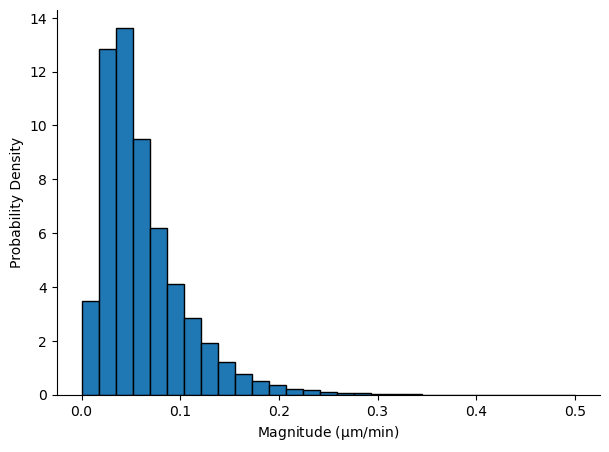

In [7]:
fig, ax = plt.subplots()
fig.set_figwidth(7)
fig.set_figheight(5)

binEdges = np.linspace(0,0.5,30)

plt.hist(mag.flatten(),bins=binEdges,density=True,edgecolor='black')

plt.xlabel("Magnitude ($\\mathrm{\\mu}$m/min)")
plt.ylabel('Probability Density')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Save and show
saveName = 'ExampleMagnitudeDistribution.png'
plt.savefig(saveDir / saveName, dpi=300, bbox_inches='tight')
plt.show()

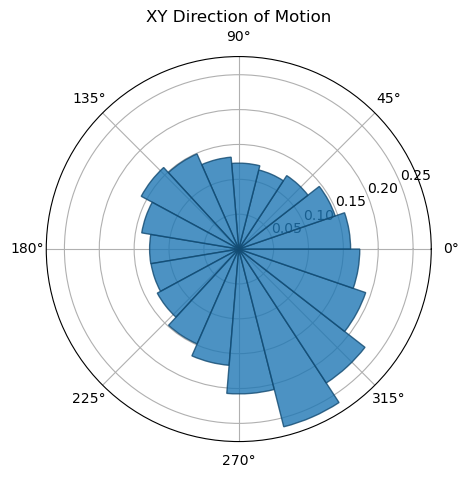

In [8]:
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
fig.set_figwidth(7)
fig.set_figheight(5)

binEdges = np.linspace(-np.pi-0.0001,np.pi+0.0001,20)
binWidth = binEdges[1]-binEdges[0]
binCenters = binEdges[1::]-binWidth

# Theta by default has a positive value when an object moves from the top of the image to the bottom.
# This is a common convention in image processing, but it can be confusing with our intuition that up is positive.
# By plotting negative theta, positive 90 degrees becomes upward motion.
counts, tmp = np.histogram(-theta.flatten(),bins=binEdges,density=True)

ax.bar(binCenters,counts,width=binWidth,edgecolor="#114970",alpha=0.8,zorder=2)
ax.set_title('XY Direction of Motion')

# Save and show
saveName = 'ExampleDirectionDistribution.png'
plt.savefig(saveDir / saveName, dpi=300, bbox_inches='tight')
plt.show()

## Example of Processing Over Time
This example shows looping over time to create a movie of theta over time and plot the mean magnitude over time.

In [ ]:
# Preallocate storage for mean magnitude
meanMag = np.full((tend+4, 1), np.nan) # Exlcuded frames on the edges of timelapse will have value NaN.

# Loop through to make the movie frames (which can be combined into any movie format)
for frame in np.arange(tstart,tend+1):

    # Reliability thresholding
    relFile = dataName + '_rel_t' + str(frame).zfill(4) + '.tiff'
    rel = tf.imread(dataDir / relFile)
    relThresh = np.percentile(rel,relPer)
    relMask = rel > relThresh

    # Load and format velocity data
    vxFile = dataName + '_vx_t' + str(frame).zfill(4) + '.tiff'
    vx = tf.imread(dataDir / vxFile)
    vx = vx*relMask # Remove unreliable vectors
    vx[vx==0] = np.nan
    vx = vx*xyscale/tscale # Put into physical units

    vyFile = dataName + '_vy_t' + str(frame).zfill(4) + '.tiff'
    vy = tf.imread(dataDir / vyFile)
    vy = vy*relMask # Remove unreliable vectors
    vy[vy==0] = np.nan
    vy = vy*xyscale/tscale # Put into physical units

    vzFile = dataName + '_vz_t' + str(frame).zfill(4) +  '.tiff'
    vz = tf.imread(dataDir / vzFile)
    vz = vz*relMask # Remove unreliable vectors
    vz[vz==0] = np.nan
    vz = vz*zscale/tscale # Put into physical units

    # Calculate useful quantities
    # Magnitude of intensity motion/change
    mag = np.sqrt(np.power(vx,2)+np.power(vy,2)+np.power(vz,2))
    # Angle in the xy plane
    theta = np.arctan2(vy,vx) # Ranges from -pi to pi
    # Angle with respect to the z-axis
    phi = np.arctan(vz/np.sqrt(np.power(vx,2)+np.power(vy,2))) # ranges from -pi/2 to pi/2

    # Mean Magnitude
    meanMag[frame] = np.nanmean(mag.flatten())

    # Set up a grid for quiver plots
    x = np.linspace(0, vx.shape[2]-1, vx.shape[2])*xyscale
    y = np.linspace(0, vx.shape[1]-1, vx.shape[1])*xyscale
    z = np.linspace(0, vx.shape[0]-1, vx.shape[0])*zscale
    X, Y, Z = np.meshgrid(x,y,z)
    X = np.moveaxis(X,-1,0)
    Y = np.moveaxis(Y,-1,0)
    Z = np.moveaxis(Z,-1,0)

    # Quiver based on Theta: 2D view of a z-slice
    fig, ax = plt.subplots()
    fig.set_figwidth(10)
    fig.set_figheight(10)

    # Use a consistent colorscale across different figures
    norm = matplotlib.colors.Normalize(vmin=-np.pi, vmax=np.pi)
    thetaPlot = norm(theta[zSlice,::gap,::gap])
    thetaPlot = thetaPlot.flatten()
    colormap = cc.m_CET_C8 # See the colorcet gallery for useful colormap choices: https://colorcet.com/gallery.html

    # Make the quiver plot
    q = ax.quiver(X[zSlice,::gap,::gap],Y[zSlice,::gap,::gap],vx[zSlice,::gap,::gap],vy[zSlice,::gap,::gap],
            color=colormap(thetaPlot),
            scale=1/25,angles='xy',scale_units='xy',units='xy',headwidth=4)

    # Format the quiver plot
    plt.xlim(np.min(X),np.max(X))
    plt.ylim(np.max(Y),np.min(Y))
    ax.set_aspect('equal')
    plt.axis('off')
    fig.set_facecolor("black")

    # Save and show
    saveName = 'ThetaQuiver_Frame' + str(frame).zfill(4) + '.png'
    plt.savefig(saveDir / saveName, dpi=300, bbox_inches='tight')
     # plt.show()
    plt.close(fig)

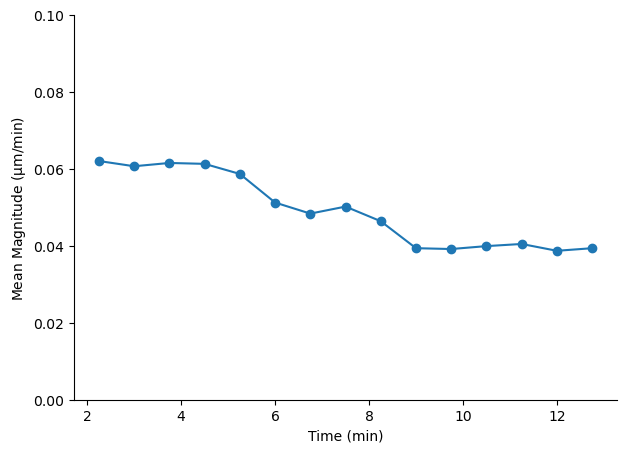

In [46]:
tVec = np.arange(0,tend+4)
tVec = tVec*tscale

# Quiver based on Theta: 2D view of a z-slice
fig, ax = plt.subplots()
fig.set_figwidth(7)
fig.set_figheight(5)

plt.plot(tVec,meanMag,'o-')
plt.ylabel('Mean Magnitude ($\\mathrm{\\mu}$m/min)')
plt.xlabel('Time (min)')

plt.ylim([0, 0.1])

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Save and show
saveName = 'ExampleMagnitudeVsTime.png'
plt.savefig(saveDir / saveName, dpi=300, bbox_inches='tight')
plt.show()